In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
from scipy import signal

import IPython.display
import cmocean as cm
import sys, os, glob
import warnings
warnings.simplefilter("ignore")

from IPython.display import Image

from dask.distributed import Client

In [ ]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0
matplotlib.rcParams['font.size'] = 15
letlab = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)',
          '(i)','(j)','(k)','(l)','(m)','(n)','(o)','(p)',
          '(q)','(r)','(s)','(t)','(u)','(v)','(w)','(x)','(y)','(z)']

In [ ]:
# Load workers:
client = Client(n_workers=14)
client

## Load datasets

In [ ]:
base = '/g/data/e14/rmh561/croco/'
base_data = base + 'archive/'
base_analysis = base + '/analysis/'

os.chdir(base_analysis + 'PAC12_75_cpl')
sys.path.append(base_analysis + 'PAC12_75_cpl/Processing_Scripts')
sys.path.append(base_analysis + 'PAC12_75_cpl/Processing_Scripts/Tracer_balance_code_LMaillard_v2')

In [ ]:
# Load custom scripts/tools:
import pac12_tools as ptools
import R_tools_fort as ftools
filt_width = 6.

In [ ]:
# define runs:
expdict = {
           'CROCO-WRF Control-E1':{'exp':'PAC12_75_cpl','expn':'exp02','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
           ,'CROCO-WRF Control-E2':{'exp':'PAC12_75_cpl','expn':'exp08','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
           ,'CROCO-WRF Control-E3':{'exp':'PAC12_75_cpl','expn':'exp09','CPL':True,'TSoffset': 2014.,'TIWoutput':True}
           ,'CROCO-WRF Control-E4':{'exp':'PAC12_75_cpl','expn':'exp10','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
           ,'CROCO-WRF Control-E5':{'exp':'PAC12_75_cpl','expn':'exp11','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
           ,'CROCO Control':{'exp':'PAC12_75','expn':'exp11','CPL':False}
          }
cont = 'CROCO Control'

In [ ]:
# Load CROCO data:
data_typs = ['mon','day','mon_hp','mon_TIWhp','mon_TIWhpstd']#'3day','day','ts_3day']
dropvars = {'mon':['omega','u_sq','v_sq','salt_sq','AKv'],
            'day':[],
            '3day':[],
            'ts_3day':[],
            'mon_hp':[],
            'mon_TIWhp':[],
            'mon_TIWhpstd':[]}
dropyears = ['2014']
#dropyears = ['2015','2016','2017','2018']
S1 = 39

data = {}
for nam in expdict.keys():
    print(nam)
    exp = expdict[nam]['exp']
    expn = expdict[nam]['expn']
    data[nam] = {}
    for typ in data_typs:
        try:
            files = sorted(glob.glob(base_data + exp + '/' + exp + '_' + expn + '/*/croco_out_' + typ + '.nc'))
            for yr in dropyears:
                files = [file for file in files if yr not in file]
            data[nam][typ] = xr.open_mfdataset(files, concat_dim="time_counter", combine="nested",data_vars='minimal', coords='minimal', compat='override',drop_variables=dropvars[typ],parallel=True,chunks={'time_counter':1}).rename({'time_counter':'time'})
            
            # Do coordinates:
            if 'TIW' in typ:
                data[nam][typ] = ptools.create_coords_CROCO_TIW(data[nam][typ],grd)
            else:
                data[nam][typ] = ptools.create_coords_CROCO(data[nam][typ])
        except:
            data[nam][typ] = None
gfiles = glob.glob(base_data + exp + '/' + exp + '_' + expn + '/*/croco_out_grd.nc')
grd = xr.open_dataset(gfiles[0],chunks={'y_rho':100,'x_rho':100})

# Generate xgcm grid object:
nam = 'CROCO-WRF Control-E1'
grid = Grid(data[nam]['mon'],coords={"x":{"center":"x_rho","inner":"x_u"},
                         "y":{"center":"y_rho","inner":"y_v"},
                         "s":{"center":"s_rho","outer":"s_w"}},periodic=False)

In [ ]:
# Load WRF data:
data_typs = {'day':'3d_1D','mon_hp':'3d_1M_hp'}#,'hr':'3d_1H','day4d':'out'}

for nam in expdict.keys():
    if expdict[nam]['CPL']:
        print(nam)
        exp = expdict[nam]['exp']
        expn = expdict[nam]['expn']
        for typ in data_typs.keys():
            try:
                files = sorted(glob.glob(base_data + exp + '/' + exp + '_' + expn + '/*/wrf' + data_typs[typ] + '*.nc'))
                for yr in dropyears:
                    files = [file for file in files if yr not in file]
                data[nam]['wrf_' + typ] = xr.open_mfdataset(files, concat_dim="time_counter", combine="nested",data_vars='minimal', coords='minimal', compat='override',parallel=True,chunks={'time_counter':1}).rename({'time_counter':'time'})
                
                # Create coords:
                data[nam]['wrf_' + typ] = ptools.create_coords_WRF(data[nam]['wrf_' + typ])
                
            except:
                data[nam]['wrf_' + typ] = None
             
# Create WRF xgcm object:
wrf_grid = ptools.create_WRF_xgcm(data['CROCO-WRF Control-E1']['wrf_day'])

## Observational products

In [9]:
# Set limit parameters for observations:
for nam in expdict.keys():
    try:
        minyr  = data[nam]['mon'].time.min('time').values.astype('datetime64[Y]').astype(int)+1970
        maxyr  = data[nam]['mon'].time.max('time').values.astype('datetime64[Y]').astype(int)+1970
        print(nam + ' minyr=' + str(minyr) + ' maxyr=' + str(maxyr))
    except:
        print('No data for ' + nam)
nam = 'CROCO-WRF Control-E1'
minyr  = data[nam]['mon'].time.min('time').values.astype('datetime64[Y]').astype(int)+1970
maxyr  = data[nam]['mon'].time.max('time').values.astype('datetime64[Y]').astype(int)+1970
minlon = data[nam]['mon'].x_rho.min('x_rho').values
maxlon = data[nam]['mon'].x_rho.max('x_rho').values
minlat = data[nam]['mon'].y_rho.min('y_rho').values
maxlat = data[nam]['mon'].y_rho.max('y_rho').values

CROCO-WRF Control-E1 minyr=2015 maxyr=2018
CROCO-WRF Control-E2 minyr=2015 maxyr=2018
CROCO-WRF Control-E3 minyr=2015 maxyr=2018
CROCO-WRF Control-E4 minyr=2015 maxyr=2018
CROCO-WRF Control-E5 minyr=2015 maxyr=2018
CROCO Control minyr=2015 maxyr=2018


In [10]:
# # Limit simulations to same years:
# data_typs = ['mon','3day','day','ts_3day']
# for nam in expdict.keys():
#     for typ in data_typs:
#         try:
#             data[nam][typ] = data[nam][typ].sel(time=slice(str(minyr) + '-01-01',str(maxyr) + '-12-31'))
#         except:
#             pass
        
# data_typs = {'day':'3d_1D','hr':'3d_1H','mon':'out'}
# for nam in expdict.keys():
#     if expdict[nam]['CPL']:
#         for typ in data_typs.keys():
#             try:
#                 data[nam]['wrf_' + typ] = data[nam]['wrf_' + typ].sel(time=slice(str(minyr) + '-01-01',str(maxyr) + '-12-31'))
#             except:
#                 pass     

In [11]:
# Observational SST:
files = []
for yr in np.arange(minyr,maxyr+1,1):
    files += sorted(glob.glob('/g/data/ua8/NOAA_OISST/AVHRR/v2-1_modified/*_' + str(yr) + '.nc'))
OISST = xr.open_mfdataset(files,concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override',parallel=True).isel(zlev=0)

OISST = OISST.sel(lon=slice(minlon,maxlon)).sel(lat=slice(minlat,maxlat))
OISST = OISST.rename({'lon':'x_rho','lat':'y_rho'})

In [12]:
# Observational SSH:
files = []
for yr in np.arange(minyr,maxyr+1,1):
    files += sorted(glob.glob('/g/data/ua8/CMEMS_SeaLevel/v2019/' + str(yr) + '/*.nc'))
CMEMS = xr.open_mfdataset(files,concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override',parallel=True)

CMEMS = CMEMS.sel(longitude=slice(minlon,maxlon)).sel(latitude=slice(minlat,maxlat))
CMEMS = CMEMS.rename({'longitude':'x_rho','latitude':'y_rho'})

In [13]:
# SODA reanalysis:
files = []
for yr in np.arange(minyr,maxyr+1,1):
    files += sorted(glob.glob('/g/data/e14/rmh561/croco/data/DATA/SODA342_PAC12_75/soda3.4.2_5dy_ocean_reg_' + str(yr) + '_*.nc'))
SODA = xr.open_mfdataset(files,concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override',parallel=True)

SODA = SODA.sel(xt_ocean=slice(minlon,maxlon)).sel(yt_ocean=slice(minlat,maxlat)).sel(xu_ocean=slice(minlon,maxlon)).sel(yu_ocean=slice(minlat,maxlat))
SODA = SODA.rename({'xt_ocean':'x_rho','yt_ocean':'y_rho'})

In [14]:
# ERA-5 surface winds:
# # NCI dataset:
# ERA5base = '/g/data/rt52/era5/single-levels/reanalysis/'
# filesU = []
# filesV = []
# for yr in np.arange(minyr,maxyr+1,1):
#     filesU += sorted(glob.glob(ERA5base + '10u/' + str(yr) + '/*.nc'))
#     filesV += sorted(glob.glob(ERA5base + '10v/' + str(yr) + '/*.nc'))
# ERA5u = xr.open_mfdataset(filesU,concat_dim="time", combine="nested",
#                   data_vars='minimal', coords='minimal', compat='override',parallel=True,chunks={'time':1})
# ERA5v = xr.open_mfdataset(filesV,concat_dim="time", combine="nested",
#                   data_vars='minimal', coords='minimal', compat='override',parallel=True,chunks={'time':1})
    
# ERA5winds = xr.merge([ERA5u,ERA5v])
# ERA5winds = ERA5winds.roll(longitude=4*180-1, roll_coords=True);
# ERA5winds = ERA5winds.assign_coords(longitude=np.where(ERA5winds.longitude.values<=0.,ERA5winds.longitude.values+360.,ERA5winds.longitude.values))
# ERA5winds = ERA5winds.rename({'longitude':'x_rho','latitude':'y_rho'})

# Pre-computed means from ERA5 CROCO-forcing files:
ERA5u = xr.open_dataset('/g/data/e14/rmh561/croco/data/DATA/ERA5_PAC12_75/U10M_2015-2018.nc')
ERA5v = xr.open_dataset('/g/data/e14/rmh561/croco/data/DATA/ERA5_PAC12_75/V10M_2015-2018.nc')
ERA5winds = xr.merge([ERA5u,ERA5v]).rename({'lon':'x_rho','lat':'y_rho'})

ERA5winds = ERA5winds.sel(x_rho=slice(minlon,maxlon)).sel(y_rho=slice(minlat,maxlat))

# Pretty validation figure

Panel 1: SST bias (colour), with mean SST (contours) and model + ERA-5 wind vectors.

Panel 2: SSH and U line plot between 220 and 240E.

Panel 2: Observed SST variability (colour) and SSH variability (contours)

Panel 3: CROCO-WRF SST variability (colour) and SSH variability (contours)

Panel 4: 

In [15]:
# Load and do calculations for OBS SST (variance and mean):
sst_hp = OISST.sst - ptools.zlp_filt(OISST.sst,filt_width)
OBS_SSTv = (sst_hp**2.).mean('time').load()
OBS_SST_mean = OISST.sst.mean('time').load()

In [16]:
# Load and do calculations for OBS SSH variance:
ssh_hp = CMEMS.adt - ptools.zlp_filt(CMEMS.adt,filt_width)
OBS_SSHv = (ssh_hp**2.).mean('time').load()
OBS_SSH_mean = (CMEMS.adt.mean('time')).load()
OBS_SSH_mean = OBS_SSH_mean - OBS_SSH_mean.mean('x_rho').mean('y_rho')

In [17]:
# SODA SSH:
SODA_SSH = (SODA.ssh.mean('time')).load()
SODA_SSH = SODA_SSH - SODA_SSH.mean('x_rho').mean('y_rho')
SODA_SSH_INT = SODA_SSH.interp(x_rho=OBS_SSH_mean.x_rho.values,y_rho=OBS_SSH_mean.y_rho.values)

In [18]:
# SODA U:
SODA_U = SODA.u.isel(st_ocean=1).mean('time').load()

In [19]:
# Load and do calculations for OBS winds:
OBS_Uwind = ERA5winds.U10M.mean('time')
OBS_Vwind = ERA5winds.V10M.mean('time')

In [20]:
# Define ensembles for CROCO-WRF:
def ens_avg(objs): 
    return(sum(objs)/len(objs))
keys = ['CROCO-WRF Control-E%01d' % (x+1) for x in range(5)]

In [21]:
# model SST variance:
SSTv = ens_avg([data[key]['mon_hp'].SST_hp_var.mean('time') for key in keys]).load()

In [22]:
# model SST:
SST = ens_avg([data[key]['mon'].temp.isel(s_rho=-1).mean('time') for key in keys]).load()

In [23]:
# model SSH:
SSH = ens_avg([data[key]['mon'].zeta.mean('time') for key in keys]).load()
SSH = SSH - SSH.mean('x_rho').mean('y_rho')

In [24]:
# model U:
U = ens_avg([data[key]['mon'].u.isel(s_rho=-1).mean('time') for key in keys]).load()

In [25]:
# model SSH variance:
SSHv = ens_avg([data[key]['mon_hp'].SSH_hp_var.mean('time') for key in keys]).load()

In [26]:
# model winds:
Uwind = ens_avg([data[key]['wrf_day'].U_PHYL1.mean('time') for key in keys]).load()
Vwind = ens_avg([data[key]['wrf_day'].V_PHYL1.mean('time') for key in keys]).load()
Uwind = Uwind.rename({'x':'x_rho','y':'y_rho'})
Vwind = Vwind.rename({'x':'x_rho','y':'y_rho'})

In [27]:
# Interpolate to OBS grid:
SST_INT = SST.interp(x_rho=OBS_SST_mean.x_rho.values,y_rho=OBS_SST_mean.y_rho.values).load()
SSTv_INT = SSTv.interp(x_rho=OBS_SSTv.x_rho.values,y_rho=OBS_SSTv.y_rho.values).load()
SSHv_INT = SSHv.interp(x_rho=OBS_SSHv.x_rho.values,y_rho=OBS_SSHv.y_rho.values).load()
Uwind_INT = Uwind.interp(x_rho=OBS_Uwind.x_rho.values,y_rho=OBS_Uwind.y_rho.values).load()
Vwind_INT = Vwind.interp(x_rho=OBS_Vwind.x_rho.values,y_rho=OBS_Vwind.y_rho.values).load()

Text(0, 0.5, 'Latitude ($^\\circ$N)')

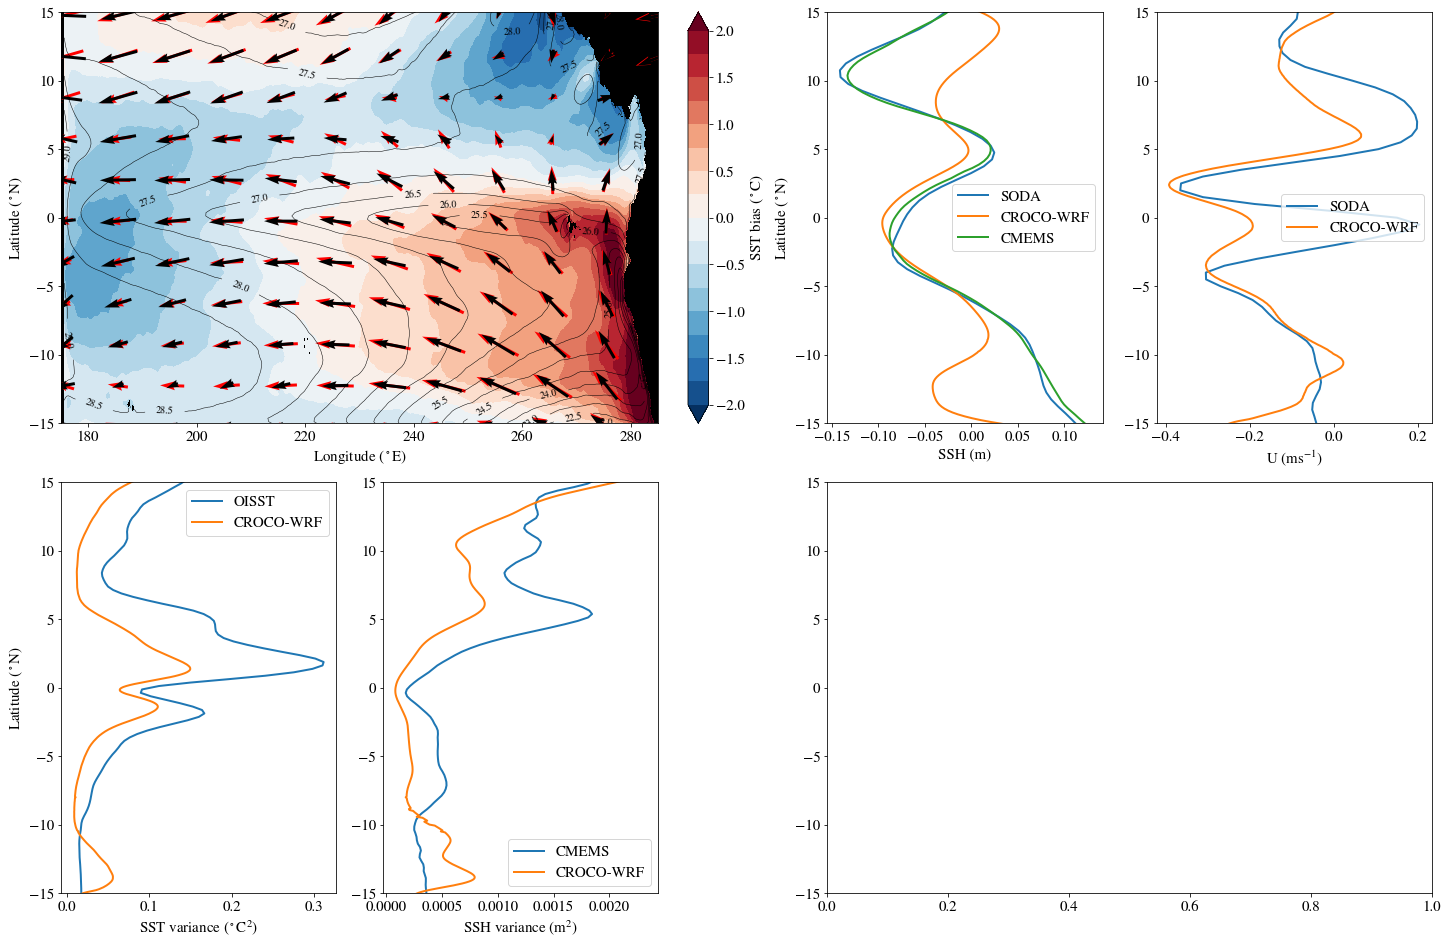

In [53]:
# Nested grids:
fig = plt.figure(figsize=(20,13), layout="constrained")

spec = fig.add_gridspec(2, 4)
ax0 = fig.add_subplot(spec[0, :2])
ax1 = fig.add_subplot(spec[0, 2])
ax2 = fig.add_subplot(spec[0, 3])
ax3 = fig.add_subplot(spec[1, 0])
ax4 = fig.add_subplot(spec[1, 1])
ax5 = fig.add_subplot(spec[1, 2:])

#### Panel 1: SST and winds:
# SST:
(SST_INT-OBS_SST_mean).plot.contourf(ax=ax0,levels=np.arange(-2.,2.25,0.25),cmap='RdBu_r',cbar_kwargs={'label':'SST bias ($^\circ$C)'})
CS = SST_INT.plot.contour(ax=ax0,levels=np.arange(0.,32.5,.5),colors='k',linewidths=0.5)
ax0.clabel(CS, CS.levels, inline=True, fontsize=10)

# Add winds:
scl = 1.e2
wind = xr.merge([OBS_Uwind,OBS_Vwind])
wind = wind.isel(x_rho=slice(None,None,40),y_rho=slice(None,None,12))
wind.plot.quiver(ax=ax0,x='x_rho',y='y_rho',u='U10M',v='V10M',color='r',scale=scl)

wind = xr.merge([Uwind_INT,Vwind_INT])
wind = wind.isel(x_rho=slice(None,None,40),y_rho=slice(None,None,12))
wind.plot.quiver(ax=ax0,x='x_rho',y='y_rho',u='U_PHYL1',v='V_PHYL1',scale=scl)

# Labelling:
ax0.set_ylabel('Latitude ($^\circ$N)')
ax0.set_xlabel('Longitude ($^\circ$E)')
ax0.set_title('')
ax0.set_ylim([-15.,15.])
ax0.set_xlim([175.,285.])
ax0.set_facecolor('k')

### Panel 2 and 3: U/SSH:
SODA_SSH.sel(x_rho=slice(220.,240.)).mean('x_rho').plot(ax=ax1,label='SODA',y='y_rho')
SSH.sel(x_rho=slice(220.,240.)).mean('x_rho').plot(ax=ax1,label='CROCO-WRF',y='y_rho')
OBS_SSH_mean.sel(x_rho=slice(220.,240.)).mean('x_rho').plot(ax=ax1,label='CMEMS',y='y_rho')
SODA_U.sel(xu_ocean=slice(220.,240.)).mean('xu_ocean').plot(ax=ax2,label='SODA',y='yu_ocean')
U.sel(x_u=slice(220.,240.)).mean('x_u').plot(ax=ax2,label='CROCO-WRF',y='y_u')
plt.ylim([-15.,15.])
ax1.legend()
ax2.legend()
ax1.set_xlabel('SSH (m)')
ax2.set_xlabel('U (ms$^{-1}$)')

### Panel 4 and 5: SST/SSH variance:
OBS_SSTv.sel(x_rho=slice(220.,240.)).mean('x_rho').plot(ax=ax3,label='OISST',y='y_rho')
SSTv.sel(x_rho=slice(220.,240.)).mean('x_rho').plot(ax=ax3,label='CROCO-WRF',y='y_rho')
OBS_SSHv.sel(x_rho=slice(220.,240.)).mean('x_rho').plot(ax=ax4,label='CMEMS',y='y_rho')
SSHv.sel(x_rho=slice(220.,240.)).mean('x_rho').plot(ax=ax4,label='CROCO-WRF',y='y_rho')
plt.ylim([-15.,15.])
ax3.legend()
ax4.legend()
ax3.set_xlabel('SST variance ($^\circ$C$^2$)')
ax4.set_xlabel('SSH variance (m$^2$)')

for axs in [ax1,ax2,ax3,ax4]:
    axs.set_ylabel('')
    axs.set_ylim([-15.,15.])
    axs.set_title('')
ax1.set_ylabel('Latitude ($^\circ$N)')
ax3.set_ylabel('Latitude ($^\circ$N)')

Text(0, 0.5, 'Latitude ($^\\circ$N)')

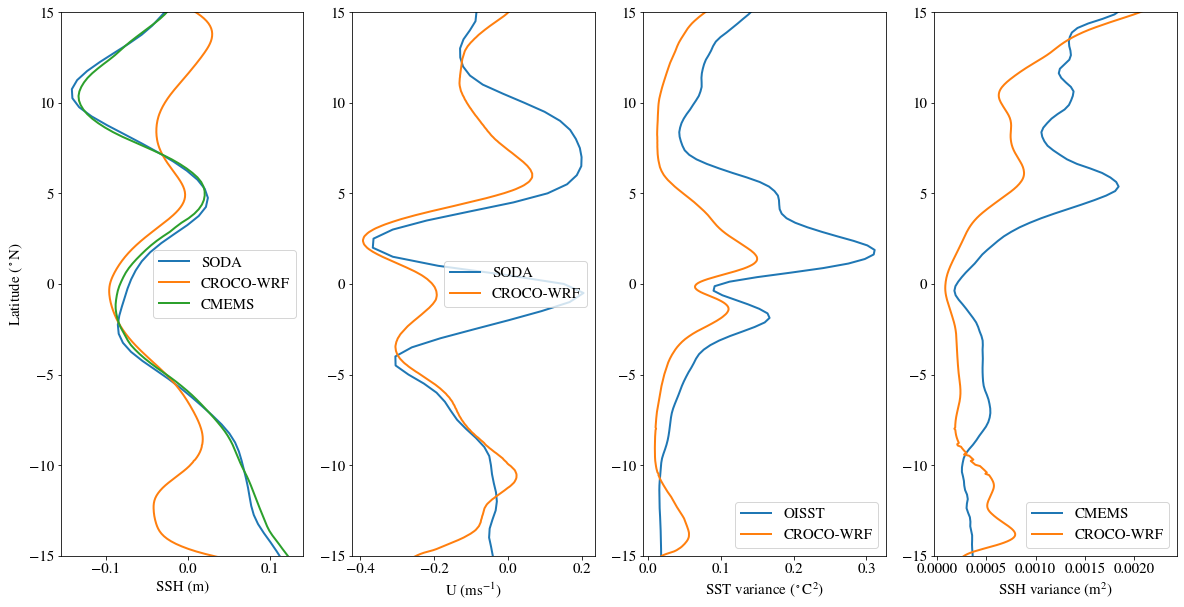

In [51]:
fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(20,10))

SODA_SSH.sel(x_rho=slice(220.,240.)).mean('x_rho').plot(ax=axes[0],label='SODA',y='y_rho')
SSH.sel(x_rho=slice(220.,240.)).mean('x_rho').plot(ax=axes[0],label='CROCO-WRF',y='y_rho')
OBS_SSH_mean.sel(x_rho=slice(220.,240.)).mean('x_rho').plot(ax=axes[0],label='CMEMS',y='y_rho')
SODA_U.sel(xu_ocean=slice(220.,240.)).mean('xu_ocean').plot(ax=axes[1],label='SODA',y='yu_ocean')
U.sel(x_u=slice(220.,240.)).mean('x_u').plot(ax=axes[1],label='CROCO-WRF',y='y_u')
plt.ylim([-15.,15.])
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel('SSH (m)')
axes[1].set_xlabel('U (ms$^{-1}$)')

OBS_SSTv.sel(x_rho=slice(220.,240.)).mean('x_rho').plot(ax=axes[2],label='OISST',y='y_rho')
SSTv.sel(x_rho=slice(220.,240.)).mean('x_rho').plot(ax=axes[2],label='CROCO-WRF',y='y_rho')
OBS_SSHv.sel(x_rho=slice(220.,240.)).mean('x_rho').plot(ax=axes[3],label='CMEMS',y='y_rho')
SSHv.sel(x_rho=slice(220.,240.)).mean('x_rho').plot(ax=axes[3],label='CROCO-WRF',y='y_rho')
plt.ylim([-15.,15.])
axes[2].legend()
axes[3].legend()
axes[2].set_xlabel('SST variance ($^\circ$C$^2$)')
axes[3].set_xlabel('SSH variance (m$^2$)')

for axs in axes:
    axs.set_ylabel('')
    axs.set_ylim([-15.,15.])
    axs.set_title('')
axes[0].set_ylabel('Latitude ($^\circ$N)')


# Add 

(-15.0, 15.0)

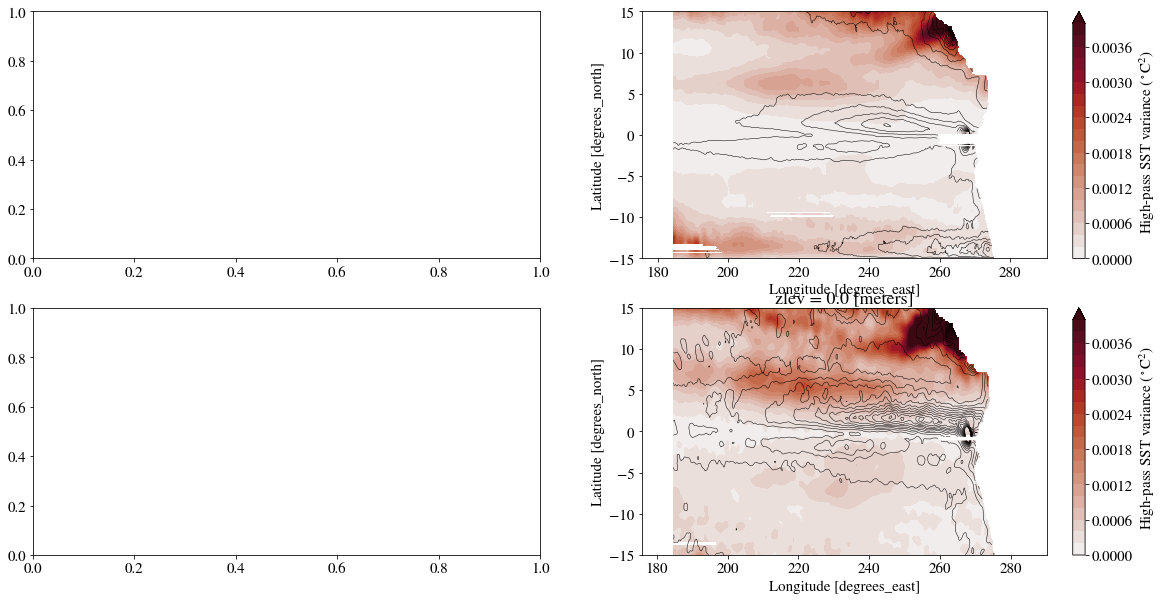

In [32]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,10))

# SST and SSH variance:
SSHv.plot.contourf(ax=axes[0][1],levels=np.arange(0.,0.0042,0.0002),cmap=cm.cm.amp,cbar_kwargs={'label':'High-pass SST variance ($^\circ$C$^2$)'})
SSTv.plot.contour(ax=axes[0][1],levels=np.arange(0.,0.95,0.05),colors='k',linewidths=0.5)
axes[0][1].set_ylim([-15.,15.])

# SST and SSH variance:
OBS_SSHv.plot.contourf(ax=axes[1][1],levels=np.arange(0.,0.0042,0.0002),cmap=cm.cm.amp,cbar_kwargs={'label':'High-pass SST variance ($^\circ$C$^2$)'})
OBS_SSTv.plot.contour(ax=axes[1][1],levels=np.arange(0.,0.95,0.05),colors='k',linewidths=0.5)
axes[1][1].set_ylim([-15.,15.])

## Vertical profiles at a given location (Annual Mean and TAO-matched times)

In [66]:
# Calculations:
LON = 220.
lonTAO = '140w'
LAT = 0.
depths = (0.,300.)

U = {}
T = {}
for key in expdict.keys():
    U[key] = data[key]['mon'].u.sel(x_u=LON,method='nearest').sel(y_u=LAT,method='nearest').load()
    T[key] = data[key]['mon'].temp.sel(x_rho=LON,method='nearest').sel(y_rho=LAT,method='nearest').load()
    
Z = data['CROCO-WRF Control-E3']['mon'].z_rho.sel(x_rho=LON,method='nearest').sel(y_rho=LAT,method='nearest').load()
SODA_U = SODA.u.sel(xu_ocean=LON,method='nearest').sel(yu_ocean=LAT,method='nearest')
SODA_T = SODA.temp.sel(x_rho=LON,method='nearest').sel(y_rho=LAT,method='nearest')
SODA_Z = -SODA.st_ocean


KeyboardInterrupt



In [60]:
# Calculate ensembles:
lst = [U,T]
runs = ['Control']
eL = 5
for obj in lst:
    for run in runs:
        obj['CROCO-WRF ' + run] = obj['CROCO-WRF ' + run + '-E1'].copy()
        for ei in range(eL-1):
            obj['CROCO-WRF ' + run] += obj['CROCO-WRF ' + run + '-E%01d' % (ei+2)]
        obj['CROCO-WRF ' + run] = obj['CROCO-WRF ' + run]/eL
cont = 'CROCO-WRF Control'

In [61]:
# TAO and Johnson data extraction function:
obs_th = 2500 # This criteria denotes the minimum number of observations at a given depth required to include this point in the comparison.
def get_TAO(lonTAO):
    # Load temperature:
    tao_file_temp = xr.open_dataset('/g/data/ik11/observations/TAO/t0n' + lonTAO + '_dy.cdf')
    tao_temp = tao_file_temp['T_20'].isel(lon=0).isel(lat=0).sel(depth=slice(0,400))
    tao_temp = tao_temp.where(tao_temp!=1.e35)
    count = np.count_nonzero(~np.isnan(tao_temp), axis=0)
    tao_temp = tao_temp.isel(depth=count>=obs_th) # Only average if more than x observations at given depth
    
    # Load zonal velocity from ADCP data:
    tao_file_u = xr.open_dataset('/g/data/ik11/observations/TAO/adcp0n' + lonTAO + '_dy.cdf')
    tao_u = tao_file_u['u_1205'].isel(lon=0).isel(lat=0).sel(depth=slice(0,400))/100.
    tao_u = tao_u.where(abs(tao_u)<=100.)
    count = np.count_nonzero(~np.isnan(tao_u), axis=0)
    tao_u = tao_u.isel(depth=count>=obs_th)  # Only average if more than x observations at given depth

    # Load zonal velocity from current data:
    tao_file_uc = xr.open_dataset('/g/data/ik11/observations/TAO/cur0n' + lonTAO + '_dy.cdf')
    tao_uc = tao_file_uc['U_320'].isel(lon=0).isel(lat=0).sel(depth=slice(0,400))/100.
    tao_uc = tao_uc.where(abs(tao_uc)<=100.)
    count = np.count_nonzero(~np.isnan(tao_uc), axis=0)
    tao_uc = tao_uc.isel(depth=count>=obs_th)  # Only average if more than x observations at given depth
    
    return tao_temp, tao_u, tao_uc

# Johnson data function:
def get_Joh(lonJoh):
    joh_file = xr.open_dataset('/g/data/ik11/observations/Johnson2002/meanfit_m.cdf')
    joh_temp = joh_file['POTEMPM']
    joh_u = joh_file['UM']

    joh_temp_eq = joh_temp.sel(ZDEP1_50=slice(0,400)).sel(YLAT11_101=0., method='nearest').sel(XLON=lonJoh,method='nearest')
    joh_u_eq = joh_u.sel(ZDEP1_50=slice(0,400)).sel(YLAT11_101=0., method='nearest').sel(XLON=lonJoh,method='nearest')
    dep_joh = joh_temp_eq.ZDEP1_50
    
    return joh_temp_eq, joh_u_eq, dep_joh

In [ ]:
# ACCESS-OM2 data:
def find_Eqpt(ekey,lon):

    expt = exptdict[ekey]['expt']
    itime = exptdict[ekey]['itime']
    ftime = exptdict[ekey]['ftime']
    
    # Extract temperature
    temp = cc.querying.getvar(expt, 'temp',session,
                          chunks={'st_ocean': None},frequency='1 monthly',
                             start_time=itime,end_time=ftime)
    temp_eq = temp.sel(st_ocean=slice(depths[0],depths[1])).sel(yt_ocean=0., method='nearest')\
                        .sel(xt_ocean=lon, method='nearest').sel(time=slice('2014-01-01','2014-12-31')).load() - 273.15
    temp_eq.attrs['units'] = 'degrees Celsius'
    
    # Extract velocity
    u = cc.querying.getvar(expt, 'u',session,
                          chunks={'st_ocean': None},frequency='1 monthly',
                           start_time=itime,end_time=ftime)
    u_eq = u.sel(st_ocean=slice(depths[0],depths[1])).sel(yu_ocean=0., method='nearest')\
                        .sel(xu_ocean=lon, method='nearest').sel(time=slice('2014-01-01','2014-12-31')).load()
    u_eq.attrs['units'] = 'cms-1'
    
    return temp_eq, u_eq

In [ ]:
OM2_1_T, OM2_1_U = find_Eqpt('1degIAF',-140.)
OM2_025_T, OM2_025_U = find_Eqpt('025degIAF',-140.)

In [ ]:
OM2_01_T, OM2_01_U = find_Eqpt('01degIAF',-140.)

In [ ]:
JOH_T, JOH_U, JOH_Z = get_Joh(220.)

In [62]:
TAO_T, TAO_U, TAO_UC = get_TAO('140w')
TAO_T = TAO_T.sel(time=slice('2015-01-01','2018-12-31'))
TAO_U = TAO_U.sel(time=slice('2015-01-01','2018-12-31'))

In [65]:
# Full annual mean:
U_ALL = {}
T_ALL = {}
for key in ['CROCO-WRF Control']:#expdict.keys():
    U_ALL[key] = U[key].mean('time').load()
    T_ALL[key] = T[key].mean('time').load()
SODA_U_ALL = SODA_U.mean('time').load()
SODA_T_ALL = SODA_T.mean('time').load()

# OM2_1_T_ALL = OM2_1_T.mean('time').load()
# OM2_025_T_ALL = OM2_025_T.mean('time').load()
# OM2_01_T_ALL = OM2_01_T.mean('time').load()
# OM2_1_U_ALL = OM2_1_U.mean('time').load()
# OM2_025_U_ALL = OM2_025_U.mean('time').load()
# OM2_01_U_ALL = OM2_01_U.mean('time').load()

Task exception was never retrieved
future: <Task finished name='Task-3792780' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/distributed/client.py:2119> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/distributed/client.py", line 2128, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-3792783' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/distributed/client.py:2119> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/distributed/client.py", line 2128, in wait
    raise AllExit()
distributed.client.AllExit


KeyboardInterrupt: 

In [ ]:
# TAO Data availability:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,8),facecolor='w')

UdL = len(TAO_U.depth)
TdL = len(TAO_T.depth)

for i in range(UdL):
    u = TAO_U.isel(depth=i)*0
    (u+TAO_U.depth.isel(depth=i).values).plot(ax=axes[0],color='k')
for i in range(TdL):
    t = TAO_T.isel(depth=i)*0
    (t+TAO_T.depth.isel(depth=i).values).plot(ax=axes[1],color='k')

    
#dates = ['2017-02-01','2018-12-31']
dates = ['2015-01-01','2018-12-31']
times = TAO_U.time.sel(time=slice(dates[0],dates[1]))

for ax in axes:
    ax.set_title('')
    ax.invert_yaxis()
    
    ax.plot([times.isel(time=0).values,times.isel(time=0).values],[0.,250.],'-r')
    ax.plot([times.isel(time=-1).values,times.isel(time=-1).values],[0.,250.],'-r')

In [ ]:
U_TAOm = {}
T_TAOm = {}
for key in ['CROCO-WRF Control']:#expdict.keys():
    U_TAOm[key] = U[key].sel(time=slice(dates[0],dates[1])).mean('time').load()
    T_TAOm[key] = T[key].sel(time=slice(dates[0],dates[1])).mean('time').load()
SODA_U_TAOm = SODA_U.sel(time=slice(dates[0],dates[1])).mean('time').load()
SODA_T_TAOm = SODA_T.sel(time=slice(dates[0],dates[1])).mean('time').load()

TAO_T_TAOm = TAO_T.sel(time=slice(dates[0],dates[1])).mean('time').load()
TAO_U_TAOm = TAO_U.sel(time=slice(dates[0],dates[1])).mean('time').load()

# OM2_1_T_TAOm = OM2_1_T.sel(time=slice(dates[0],dates[1])).mean('time').load()
# OM2_025_T_TAOm = OM2_025_T.sel(time=slice(dates[0],dates[1])).mean('time').load()
# OM2_01_T_TAOm = OM2_01_T.sel(time=slice(dates[0],dates[1])).mean('time').load()
# OM2_1_U_TAOm = OM2_1_U.sel(time=slice(dates[0],dates[1])).mean('time').load()
# OM2_025_U_TAOm = OM2_025_U.sel(time=slice(dates[0],dates[1])).mean('time').load()
# OM2_01_U_TAOm = OM2_01_U.sel(time=slice(dates[0],dates[1])).mean('time').load()

In [ ]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,8),facecolor='w')

keys = ['CROCO-WRF Control']

for key in keys:
    axes[0].plot(U_TAOm[key],Z[key],linewidth=3,label=key + ' (matched times)')
axes[0].plot(SODA_U_TAOm,SODA_Z,linewidth=3,label='SODA (matched times)')
axes[0].plot(TAO_U_TAOm,-TAO_U.depth,linewidth=3,label='TAO (matched times)')
# #axes[0].plot(OM2_1_U_TAOm,-OM2_1_U_TAOm.st_ocean,linewidth=3,label='ACCESS-OM2 (matched times)')
# #axes[0].plot(OM2_025_U_TAOm,-OM2_025_U_TAOm.st_ocean,linewidth=3,label='ACCESS-OM2-025 (matched times)')
# #axes[0].plot(OM2_01_U_TAOm,-OM2_01_U_TAOm.st_ocean,linewidth=3,label='ACCESS-OM2-01 (matched times)')

#for key in expdict.keys():
#    axes[0].plot(U_ALL[key],Z[key],linestyle='solid',label=key + ' All')
#axes[0].plot(SODA_U_ALL,SODA_Z,linestyle='solid',label='SODA All')
#axes[0].plot(JOH_U,-JOH_Z,linestyle='solid',label='Johnson et al')
#axes[0].plot(OM2_1_U_ALL,-OM2_1_U_ALL.st_ocean,linestyle='dashed',label='ACCESS-OM2 All')
#axes[0].plot(OM2_025_U_ALL,-OM2_025_U_ALL.st_ocean,linestyle='dashed',label='ACCESS-OM2-025 All')
#axes[0].plot(OM2_01_U_ALL,-OM2_01_U_ALL.st_ocean,linestyle='dashed',label='ACCESS-OM2-01 All')

for key in keys:
    axes[1].plot(T_TAOm[key],Z[key],linewidth=3,label=key + ' (matched times)')
axes[1].plot(SODA_T_TAOm,SODA_Z,linewidth=3,label='SODA (matched times)')
axes[1].plot(TAO_T_TAOm,-TAO_T.depth,linewidth=3,label='TAO (matched times)')
# axes[1].plot(OM2_1_T_TAOm,-OM2_1_T_TAOm.st_ocean,linewidth=3,label='ACCESS-OM2 (matched times)')
# axes[1].plot(OM2_025_T_TAOm,-OM2_025_T_TAOm.st_ocean,linewidth=3,label='ACCESS-OM2-025 (matched times)')
# axes[1].plot(OM2_01_T_TAOm,-OM2_01_T_TAOm.st_ocean,linewidth=3,label='ACCESS-OM2-01 (matched times)')

#for key in expdict.keys():
#   axes[1].plot(T_ALL[key],Z[key],linestyle='solid',label=key + ' All')
# axes[1].plot(SODA_T_ALL,SODA_Z,linestyle='solid',label='SODA All')
# axes[1].plot(JOH_T,-JOH_Z,linestyle='solid',label='Johnson et al')
# axes[1].plot(OM2_1_T_ALL,-OM2_1_T_ALL.st_ocean,linestyle='dashed',label='ACCESS-OM2 All')
# axes[1].plot(OM2_025_T_ALL,-OM2_025_T_ALL.st_ocean,linestyle='dashed',label='ACCESS-OM2-025 All')
# axes[1].plot(OM2_01_T_ALL,-OM2_01_T_ALL.st_ocean,linestyle='dashed',label='ACCESS-OM2-01 All')

axes[0].set_ylabel('Depth (m)')
axes[0].legend()
axes[0].set_title('Zonal Velocity at 140W, 0N ' + dates[0] + ' ' + dates[1])
axes[1].set_xlim([10.,30.])
axes[1].legend()
axes[1].set_title('Temperature at 140W, 0N ' + dates[0] + ' ' + dates[1])

for ax in axes:
    ax.set_ylim([-300.,0.])
    ax.grid()

plt.tight_layout()
#plt.savefig('Validation_Figures/140W_VerticalProfiles_CROCO_CROCO-WRF_TAO_SODA.png',dpi=150)

## Annual Mean Surface Properties:

In [ ]:
# Calculations
OBS_SST = OISST.sst.mean('time').load()
OBS_SSH = (CMEMS.adt.mean('time') - CMEMS.adt.mean('time').mean('x_rho').mean('y_rho')).load()

#SODA_SST = SODA.temp.isel(st_ocean=0).mean('time').load()
#SODA_SSH = SODA.ssh.mean('time') - SODA.ssh.mean('time').mean('x_rho').mean('y_rho')
SODA_SSS = SODA.salt.isel(st_ocean=0).mean('time')

#SODA_SST_INT = SODA_SST.interp(x_rho=OBS_SST.x_rho.values,y_rho=OBS_SST.y_rho.values)
#SODA_SSH_INT = SODA_SSH.interp(x_rho=OBS_SST.x_rho.values,y_rho=OBS_SST.y_rho.values)
SODA_SSS_INT = SODA_SSS.interp(x_rho=OBS_SST.x_rho.values,y_rho=OBS_SST.y_rho.values).load()

SST_INT = {}
SSH_INT = {}
SSS_INT = {}

for key in expdict.keys():
    print(key)
    SST = data[key]['mon'].temp.isel(s_rho=-1).mean('time')
    SSH = data[key]['mon'].zeta.mean('time') - data[key]['mon'].zeta.mean('time').mean('x_rho').mean('y_rho')
    SSS = data[key]['mon'].salt.isel(s_rho=-1).mean('time')
    SST_INT[key] = SST.interp(x_rho=OBS_SST.x_rho.values,y_rho=OBS_SST.y_rho.values).load()
    SSH_INT[key] = SSH.interp(x_rho=OBS_SST.x_rho.values,y_rho=OBS_SST.y_rho.values).load()
    SSS_INT[key] = SSS.interp(x_rho=OBS_SST.x_rho.values,y_rho=OBS_SST.y_rho.values).load()

In [ ]:
## Annual mean SST:
fig, axes = plt.subplots(nrows=3,ncols=3,figsize=(30,20),facecolor='w')

OBS_SST.plot(ax=axes[0][0],vmin=18.,vmax=29.,cmap='RdBu_r')
axes[0][0].set_title('OISST SST (degC)')

OBS_SSH.plot(ax=axes[0][1],vmin=-0.4,vmax=0.4,cmap='RdBu_r')
axes[0][1].set_title('CMEMS SSH (m)')

SODA_SSS.plot(ax=axes[0][2],vmin=33.,vmax=36.,cmap=cm.cm.haline)
axes[0][2].set_title('SODA SSS [psu]')

for i, key in enumerate(expdict.keys()):
    (SST_INT[key]-OBS_SST).plot(ax=axes[i+1][0],vmin=-2.5,vmax=2.5,cmap='RdBu_r')
    axes[i+1][0].set_title(key + ' - OBS SST [degC]')
    (SSH_INT[key]-OBS_SSH).plot(ax=axes[i+1][1],vmin=-0.15,vmax=0.15,cmap='RdBu_r')
    axes[i+1][1].set_title(key + ' - OBS SSH [m]')
    (SSS_INT[key]-SODA_SSS_INT).plot(ax=axes[i+1][2],vmin=-0.5,vmax=0.5,cmap='RdBu_r')
    axes[i+1][2].set_title(key + ' - SODA SSS [psu]')

plt.tight_layout()
plt.savefig('Validation_Figures/CROCO_CROCO-WRF_2015-2018_SurfaceBiases.png',dpi=100)

In [ ]:
# Calculations
SWFLX = {}
TAUU = {}
TAUV = {}

for key in expdict.keys():
    print(key)
    SWFLX[key] = data[key]['mon'].swflx.mean('time').load()
    TAUU[key] = data[key]['mon'].sustr.mean('time').load()
    TAUV[key] = data[key]['mon'].svstr.mean('time').load()

In [ ]:
## Annual mean SST:
fig, axes = plt.subplots(nrows=3,ncols=3,figsize=(30,20),facecolor='w')

cont = 'CROCO Control'
pert = 'CROCO-WRF Control'

SWFLX[cont].plot(ax=axes[0][0],vmin=-1.5,vmax=1.5,cmap='RdBu_r')
axes[0][0].set_title(cont + ' surface volume flux [cms-1]')
TAUU[cont].plot(ax=axes[0][1],vmin=-0.15,vmax=0.15,cmap='RdBu_r')
axes[0][1].set_title(cont + ' zonal wind stress [Nm-2]')
TAUV[cont].plot(ax=axes[0][2],vmin=-0.15,vmax=0.15,cmap='RdBu_r')
axes[0][1].set_title(cont + ' meridional wind stress [Nm-2]')

SWFLX[pert].plot(ax=axes[1][0],vmin=-1.5,vmax=1.5,cmap='RdBu_r')
axes[1][0].set_title(pert + ' surface volume flux [cms-1]')
TAUU[pert].plot(ax=axes[1][1],vmin=-0.15,vmax=0.15,cmap='RdBu_r')
axes[1][1].set_title(pert + ' zonal wind stress [Nm-2]')
TAUV[pert].plot(ax=axes[1][2],vmin=-0.15,vmax=0.15,cmap='RdBu_r')
axes[1][1].set_title(pert + ' meridional wind stress [Nm-2]')
    
(SWFLX[pert]-SWFLX[cont]).plot(ax=axes[2][0],vmin=-1.,vmax=1.,cmap='RdBu_r')
axes[2][0].set_title(pert + ' surface volume flux [cms-1]')
(TAUU[pert]-TAUU[cont]).plot(ax=axes[2][1],vmin=-0.05,vmax=0.05,cmap='RdBu_r')
axes[2][1].set_title(pert + ' zonal wind stress [Nm-2]')
(TAUV[pert]-TAUV[cont]).plot(ax=axes[2][2],vmin=-0.05,vmax=0.05,cmap='RdBu_r')
axes[2][1].set_title(pert + ' meridional wind stress [Nm-2]')

plt.tight_layout()
plt.savefig('Validation_Figures/CROCO_CROCO-WRF_2015-2018_P-E_TAU_Differences.png',dpi=100)

## Seasonal cycle of equatorial SST:

In [54]:
# Calculations
OBS_SST = OISST.sst.groupby('time.month').mean('time').sel(y_rho=slice(-5.,5.)).mean('y_rho').rename({'month':'time'}).load()
SST_INT[key] = {}
for key in expdict.keys():
    SST = data[key]['mon'].temp.isel(s_rho=-1).sel(y_rho=slice(-5.,5.)).mean('y_rho').groupby('time.month').mean('time').rename({'month':'time'})
#    SST["time"] = OBS_SST.time
    SST_INT[key] = SST.interp(x_rho=OBS_SST.x_rho.values).load()

NameError: name 'key' is not defined

In [ ]:
## Seasonal cycle of equatorial SST:
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(20,12),facecolor='w')

OBS_SST.plot.contourf(levels=np.arange(23.,29.5,.5),ax=axes[0][0],cmap='RdBu_r')
axes[0][0].set_title('OISST SST (degC)')

for i, key in enumerate(expdict.keys()):
    SST_INT[key].plot.contourf(levels=np.arange(23.,29.5,.5),ax=axes[0][i+1],cmap='RdBu_r')
    axes[0][i+1].set_title(key + ' SST (degC)')
    
    (SST_INT[key]-OBS_SST).plot.contourf(levels=np.arange(-2.5,2.75,.25),ax=axes[1][i+1],cmap='RdBu_r')
    axes[1][i+1].set_title(key + ' - OBS SST (degC)')
axes[1][0].set_axis_off()

plt.tight_layout()
#plt.savefig('Validation_Figures/Seasonal_Cycle_CROCO_CROCO-WRF_2015-2018_Equatorial_SST_Bias.png',dpi=100)

# Nino 3.4 time series and Temperature bias

In [ ]:
# Load Nino 3.4 index (pre-processed in scalar_spinup_analysis.ipynb):
keys = ['CROCO Control','CROCO-WRF Control']
N34 = {}
for nam in keys:
    name = base_data+expdict[nam]['exp'] + '/' + expdict[nam]['exp'] + '_' + expdict[nam]['expn'] + '_N34.nc'

    if (os.path.exists(name)):
        N34[nam] = xr.open_dataset(name).temp.rename({'time_counter':'time'})
    else:
        print('N34 not found for run ' + nam + ' - run processing step first?')

# Sattellite N34:
N34['OISST'] = OISST.sst.sel(x_rho=slice(-170.+360.,-120.+360.)).sel(y_rho=slice(-5.,5.)).resample(time="1M").mean().mean('x_rho').mean('y_rho')
        
# Time range:
minyr = 2014
maxyr = 2017
for nam in keys + ['OISST']:
    N34[nam] = N34[nam].sel(time=slice(str(minyr) + '-01-01',str(maxyr) + '-12-31')).load()
    
# Concate CROCO-WRF Control and Spinup:
N34['CROCO-WRF Control'] = xr.concat([N34['CROCO-WRF Spinup'],N34['CROCO-WRF Control']],dim='time')

In [ ]:
# SST biases:
times = ['2015-01-01','2016-12-31']
SST = {}
SST['OISST'] = OISST.sst.sel(time=slice(times[0],times[1])).mean('time').load()
for nam in ['CROCO Control','CROCO-WRF Control']:
    print(nam)
    SST[nam] = data[nam]['mon'].temp.isel(s_rho=-1).sel(time=slice(times[0],times[1])).mean('time').interp(x_rho=OISST.x_rho.values,y_rho=OISST.y_rho.values).load()

In [ ]:
fig = plt.figure(figsize=(8,8),facecolor='w')
grid = plt.GridSpec(5, 2, wspace=0.1, hspace=2.)

axes = ['','','']
axes[0] = plt.subplot(grid[0:3,:])
axes[1] = plt.subplot(grid[3:,0])
axes[2] = plt.subplot(grid[3:,1])

N34['CROCO Control'].plot(ax=axes[0],label='CROCO')
N34['CROCO-WRF Control'].plot(ax=axes[0],label='CROCO-WRF')
N34['OISST'].plot(ax=axes[0],label='NOAA OISST',color='black',linestyle='dashed')
axes[0].legend()
axes[0].grid()
axes[0].set_title('')
axes[0].set_ylabel('Ni$\~{n}$o 3.4 SST ($^\circ$C)')
axes[0].set_xlabel('')

(SST['CROCO Control']-SST['OISST']).plot(ax=axes[1],cmap='RdBu_r',vmin=-2.5,vmax=2.5)
(SST['CROCO-WRF Control']-SST['OISST']).plot(ax=axes[2],cmap='RdBu_r',vmin=-2.5,vmax=2.5)

N34minlon = 190.
N34maxlon = 240.
N34minlat = -5.
N34maxlat = 5.
for axs in [axes[1],axes[2]]:
    axs.set_xlabel('Longitude ($^\circ$E)')
    axs.set_ylabel('Latitude ($^\circ$E)')
    axs.set_facecolor('black')
    
    axs.add_patch(Rectangle((N34minlon, N34minlat), N34maxlon-N34minlon, N34maxlat-N34minlat,
             edgecolor = 'black',
             linestyle = 'dashed',
             fill=False,
             lw=1))
axes[2].set_ylabel('')
axes[1].set_title('CROCO SST bias ($^\circ$C)')
axes[2].set_title('CROCO-WRF SST bias ($^\circ$C)')

plt.tight_layout()
plt.savefig('N34_Valid.png',dpi=100)

## Longitude surface profiles:

In [ ]:
LON = 220.
LON_OM2 = -140.

# Calculations
OBS_SST = OISST.sel(x_rho=LON,method='nearest').sst.mean('time').load()
OBS_SSH = CMEMS.adt.sel(x_rho=LON,method='nearest').mean('time') - CMEMS.adt.sel(x_rho=LON,method='nearest').mean('time').mean('y_rho')
OBS_SSH.load()

SST = {}
SSH = {}
U = {}
for key in expdict.keys():
    SST[key] = data[key]['mon'].sel(x_rho=LON,method='nearest').temp.isel(s_rho=-1).mean('time').load()
    SSH[key] = data[key]['mon'].sel(x_rho=LON,method='nearest').zeta.mean('time') - data[key]['mon'].zeta.sel(x_rho=LON,method='nearest').mean('time').mean('y_rho')
    SSH[key].load()
    U[key] = data[key]['mon'].u.sel(x_u=LON,method='nearest').isel(s_rho=-1).mean('time').load()

SODA_SST = SODA.temp.sel(x_rho=LON,method='nearest').isel(st_ocean=0).mean('time').load()
SODA_SSH = SODA.ssh.sel(x_rho=LON,method='nearest').mean('time') - SODA.ssh.sel(x_rho=LON,method='nearest').mean('time').mean('y_rho')
SODA_SSH.load()
SODA_U = SODA.u.sel(xu_ocean=LON,method='nearest').isel(st_ocean=1).mean('time').load()

In [ ]:
# ACCESS-OM2 data:
def find_lonprof(ekey,lon):

    expt = exptdict[ekey]['expt']
    itime = exptdict[ekey]['itime']
    ftime = exptdict[ekey]['ftime']
    
    # Extract temperature
    temp = cc.querying.getvar(expt, 'temp',session,
                          chunks={'st_ocean': None},frequency='1 monthly',
                             start_time=itime,end_time=ftime)
    temp_prof = temp.isel(st_ocean=0).sel(yt_ocean=slice(minlat,maxlat))\
                        .sel(xt_ocean=lon, method='nearest').sel(time=slice('2014-01-01','2014-12-31')).mean('time').load() - 273.15
    temp_prof.attrs['units'] = 'degrees Celsius'
    
    # Extract velocity
    u = cc.querying.getvar(expt, 'u',session,
                          chunks={'st_ocean': None},frequency='1 monthly',
                           start_time=itime,end_time=ftime)
    u_prof = u.isel(st_ocean=0).sel(yu_ocean=slice(minlat,maxlat))\
                        .sel(xu_ocean=lon, method='nearest').sel(time=slice('2014-01-01','2014-12-31')).mean('time').load()
    u_prof.attrs['units'] = 'ms-1'
    
    # Extract ssh
    ssh = cc.querying.getvar(expt, 'sea_level',session,frequency='1 monthly',
                             start_time=itime,end_time=ftime)
    ssh_prof = ssh.sel(yt_ocean=slice(minlat,maxlat))\
                        .sel(xt_ocean=lon, method='nearest').sel(time=slice('2014-01-01','2014-12-31')).mean('time').load()
    ssh_prof = ssh_prof - ssh_prof.mean('yt_ocean')
    
    return temp_prof, u_prof, ssh_prof

In [ ]:
OM2_1_T, OM2_1_U, OM2_1_SSH = find_lonprof('1degIAF',LON_OM2)
OM2_025_T, OM2_025_U, OM2_025_SSH = find_lonprof('025degIAF',LON_OM2)

In [ ]:
OM2_01_T, OM2_01_U, OM2_01_SSH = find_lonprof('01degIAF',LON_OM2)

In [ ]:
## Latitude line plots:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(20,8),facecolor='w')

for key in expdict.keys():
    SST[key].plot(y='y_rho',ax=axes[0],label=key)
SODA_SST.plot(y='y_rho',ax=axes[0],label='SODA')
OBS_SST.plot(y='y_rho',ax=axes[0],label='OISST')

#OM2_1_T.plot(y='yt_ocean',ax=axes[0],label='ACCESS-OM2')
#OM2_025_T.plot(y='yt_ocean',ax=axes[0],label='ACCESS-OM2-025')
#OM2_01_T.plot(y='yt_ocean',ax=axes[0],label='ACCESS-OM2-01')
axes[0].set_title('140W SST [degC]')
axes[0].legend()

for key in expdict.keys():
    SSH[key].plot(y='y_rho',ax=axes[1],label=key)
SODA_SSH.plot(y='y_rho',ax=axes[1],label='SODA')
OBS_SSH.plot(y='y_rho',ax=axes[1],label='CMEMS')

#OM2_1_SSH.plot(y='yt_ocean',ax=axes[0],label='ACCESS-OM2')
#OM2_025_SSH.plot(y='yt_ocean',ax=axes[1],label='ACCESS-OM2-025')
#OM2_01_SSH.plot(y='yt_ocean',ax=axes[1],label='ACCESS-OM2-01')
axes[1].set_title('140W SSH [m]')
axes[1].legend()

for key in expdict.keys():
    U[key].plot(y='y_u',ax=axes[2],label=key)
SODA_U.plot(y='yu_ocean',ax=axes[2],label='SODA')

#OM2_1_U.plot(y='yu_ocean',ax=axes[2],label='ACCESS-OM2')
#OM2_025_U.plot(y='yu_ocean',ax=axes[2],label='ACCESS-OM2-025')
#OM2_01_U.plot(y='yu_ocean',ax=axes[2],label='ACCESS-OM2-01')
axes[2].set_title('140W U [ms-1]')
#axes[2].legend()
axes[2].set_xlim([-0.5,0.5])

for ax in axes:
    ax.grid()

plt.tight_layout()
plt.savefig('Validation_Figures/Latitude_Profile_CROCO_CROCO-WRF_140W_SST_SSH_U_2014-2018.png',dpi=100)

## Longitude-depth and latitude-depth profiles of temperature and zonal velocity:

In [ ]:
# Region definitions:

depths = (0,300)    # Define depth range for all plots [m]

EqPlons = (175.,275.) # Define longitude range for longitude-depth plot [degrees]
EqPlat = 0.         # Define latitude for longitude-depth plot [degrees]

Ltlon = -140.       # Define longitude for latitude-depth plot [degrees]
ObsLtlon = 220.     # Define longitude for latitude-depth plot for Johnson observations. [degrees]
Ltlats = (-8,10)    # Define latitudes for latitude-depth plot [degrees]

In [ ]:
# Johnson observation calculations:

# Define Johnson observations file:
obs_file = xr.open_dataset('/g/data/ik11/observations/Johnson2002/meanfit_m.cdf')

# Extract temperature:
obs_temp = obs_file['POTEMPM']
obs_temp_eq = obs_temp.sel(ZDEP1_50=slice(depths[0],depths[1])).sel(YLAT11_101=EqPlat, method='nearest')
obs_temp_140w = obs_temp.sel(ZDEP1_50=slice(depths[0],depths[1])).sel(XLON=ObsLtlon, method='nearest')
lat_obs = obs_temp_140w.YLAT11_101
lon_obs = obs_temp_eq.XLON
dep_obs = obs_temp_eq.ZDEP1_50

# Extract zonal velocity:
obs_u = obs_file['UM']
obs_u_eq = obs_u.sel(ZDEP1_50=slice(depths[0],depths[1])).sel(YLAT11_101=EqPlat, method='nearest')
obs_u_140w = obs_u.sel(ZDEP1_50=slice(depths[0],depths[1])).sel(XLON=ObsLtlon, method='nearest')
lat_u_obs = obs_u_140w.YLAT11_101
lon_u_obs = obs_u_eq.XLON

In [ ]:
# CROCO calculations:
xind = abs(data['mon'].x_rho-220.).argmin().values
yind = abs(data['mon'].y_rho).argmin().values

# 140W depth-lat
u_140w = data['mon'].u.isel(x_u=xind).mean('time').load()
temp_140w = data['mon'].temp.isel(x_rho=xind).mean('time').load()
z_140w = data['mon'].z_rho.isel(x_rho=xind).load()

# Equatorial depth-longitude:
u_eq = data['mon'].u.isel(y_u=yind).mean('time').load()
temp_eq = data['mon'].temp.isel(y_rho=yind).mean('time').load()
z_eq = data['mon'].z_rho.isel(y_rho=yind).load()

In [ ]:
# SODA calculations:
SODA_u_140w = SODA.u.sel(xu_ocean=220.,method='nearest').mean('time').load()
SODA_temp_140w = SODA.temp.sel(x_rho=220.,method='nearest').mean('time').load()

SODA_u_eq = SODA.u.sel(yu_ocean=0.,method='nearest').mean('time').load()
SODA_temp_eq = SODA.temp.sel(y_rho=0.,method='nearest').mean('time').load()

In [ ]:
# Define colobar limits and labels:
clevelsT = np.arange(10.,30.,1.)
clevelsU = np.arange(-50,130,10)

fig = plt.figure(figsize=(12,12))

# Plot equatorial slice:
plt.subplot(3,2,1)
xv, yv = np.meshgrid(temp_eq.x_rho,z_eq.isel(x_rho=0))
p1=plt.contourf(xv,z_eq,temp_eq,cmap=cm.cm.thermal, 
                               levels=clevelsT,
                               add_colorbar=False, extend='both')
plt.contour(xv,z_eq,temp_eq,levels=clevelsT,colors='k',linewidths=0.5)
xv, yv = np.meshgrid(u_eq.x_u,z_eq.isel(x_rho=0))
p2=plt.contour(xv,z_eq.isel(x_rho=slice(0,-1)),100*u_eq,colors='w',levels=clevelsU,linewidths=1)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.ylim([-300.,0.])
plt.xlim(EqPlons)
#plt.gca().invert_yaxis()
plt.xlabel('')
plt.ylabel('Depth (m)')
plt.title(sim_name + exp + ' Equatorial Slice')

# Plot latitude-depth slice:
plt.subplot(3,2,2)
xv, yv = np.meshgrid(temp_140w.y_rho,z_140w.isel(y_rho=0))
p3=plt.contourf(xv,z_140w,temp_140w,cmap=cm.cm.thermal, 
                               levels=clevelsT,
                               add_colorbar=False, extend='both')
plt.contour(xv,z_140w,temp_140w,levels=clevelsT,colors='k',linewidths=0.5)
xv, yv = np.meshgrid(u_140w.y_u,z_140w.isel(y_rho=0))
p4=plt.contour(xv,z_140w,100*u_140w,colors='w',levels=clevelsU,linewidths=1)
plt.clabel(p4, fmt='%2.0f', colors='black', fontsize=10)
plt.ylim([-300.,0.])
plt.xlim(Ltlats)
#plt.gca().invert_yaxis()
plt.xlabel('')
plt.ylabel('')
plt.title(sim_name + exp + ' 140W slice')

# Plot equatorial slice:
plt.subplot(3,2,3)
xv, yv = np.meshgrid(SODA_temp_eq.x_rho,SODA.st_ocean)
p1=plt.contourf(xv,yv,SODA_temp_eq,cmap=cm.cm.thermal, 
                               levels=clevelsT,
                               add_colorbar=False, extend='both')
plt.contour(xv,yv,SODA_temp_eq,levels=clevelsT,colors='k',linewidths=0.5)
xv, yv = np.meshgrid(SODA_u_eq.xu_ocean,SODA.st_ocean)
p2=plt.contour(xv,yv,100*SODA_u_eq,colors='w',levels=clevelsU,linewidths=1)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.ylim([0.,300.])
plt.gca().invert_yaxis()
plt.xlim(EqPlons)
plt.xlabel('')
plt.ylabel('Depth (m)')
plt.title('SODA Equatorial Slice')

# Plot latitude-depth slice:
plt.subplot(3,2,4)
xv, yv = np.meshgrid(SODA_temp_140w.y_rho,SODA.st_ocean)
p3=plt.contourf(xv,yv,SODA_temp_140w,cmap=cm.cm.thermal, 
                               levels=clevelsT,
                               add_colorbar=False, extend='both')
plt.contour(xv,yv,SODA_temp_140w,levels=clevelsT,colors='k',linewidths=0.5)
xv, yv = np.meshgrid(SODA_u_140w.yu_ocean,SODA.st_ocean)
p4=plt.contour(xv,yv,100*SODA_u_140w,colors='w',levels=clevelsU,linewidths=1)
plt.clabel(p4, fmt='%2.0f', colors='black', fontsize=10)
plt.ylim([0.,300.])
plt.xlim(Ltlats)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.ylabel('')
plt.title('SODA 140W slice')

# Plot observational equatorial slice:
plt.subplot(3,2,5)
p1 = plt.contourf(lon_obs, dep_obs, obs_temp_eq, cmap=cm.cm.thermal, levels=clevelsT, extend='both')
plt.contour(lon_obs, dep_obs, obs_temp_eq, colors='k', levels=clevelsT,linewidths=0.5)
p2 = plt.contour(lon_u_obs, dep_obs, obs_u_eq*100, colors = 'w', linewidths=1,levels=clevelsU)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.ylim([0.,300.])
plt.gca().invert_yaxis()
plt.xlim(EqPlons)
plt.xlabel('Longitude')
plt.ylabel('Depth (m)')
plt.title('Observations (Johnson)')

# Plot observational latitude-depth slice:
plt.subplot(3,2,6)
p1 = plt.contourf(lat_obs, dep_obs, obs_temp_140w, cmap=cm.cm.thermal, levels=clevelsT, extend='both')
plt.contour(lat_obs, dep_obs, obs_temp_140w, colors='k', levels=clevelsT,linewidths=0.5)
p2 = plt.contour(lat_u_obs, dep_obs, obs_u_140w*100, colors = 'w', linewidths=1,levels=clevelsU)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.ylim([0.,300.])
plt.gca().invert_yaxis()
plt.xlim(Ltlats)
plt.xlabel('Latitude')
plt.ylabel('')
plt.title('Observations (Johnson)')

# Add colorbar:
ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical', extend='both')
cb.ax.set_ylabel('Temperature (°C)')
fig.tight_layout(rect=[0, 0.03, 0.9, 0.95])
plt.savefig('CROCO-WRF_PAC12_75_cpl_SODA_Johnson_Comparison.png',dpi=150)

## TIW SST/SSH variability: Longitude high-pass filtering

In [ ]:
# Get data:
OBS_SST = OISST.sst
OBS_SST_DX = (OISST.x_rho[1]-OISST.x_rho[0]).values
OBS_SSH = CMEMS.sla
OBS_SSH_DX = (CMEMS.x_rho[1]-CMEMS.x_rho[0]).values
OBS_V = CMEMS.vgos

SST = {}
SSH = {}
V = {}
for key in expdict.keys():
    SST[key] = data[key]['day'].temp_surf
    SSH[key] = data[key]['day'].zeta
    V[key] = data[key]['day'].v_surf
DX = (data['CROCO Control']['day'].x_rho[1]-data['CROCO Control']['day'].x_rho[0]).values

ln_hp_filt = 12.0

In [ ]:
# Limit data sets for speed:
lats = -2., 10.
lons = 180., 275.
#times = '2016-07-01','2017-03-01'
times = '2016-11-01','2016-12-01'

OBS_SST = OBS_SST.sel(time=slice(times[0],times[1])).sel(y_rho=slice(lats[0],lats[1])).sel(x_rho=slice(lons[0],lons[1]))
OBS_SSH = OBS_SSH.sel(time=slice(times[0],times[1])).sel(y_rho=slice(lats[0],lats[1])).sel(x_rho=slice(lons[0],lons[1]))
OBS_V = OBS_V.sel(time=slice(times[0],times[1])).sel(y_rho=slice(lats[0],lats[1])).sel(x_rho=slice(lons[0],lons[1]))
for key in expdict.keys():
    SST[key] = SST[key].sel(time=slice(times[0],times[1])).sel(y_rho=slice(lats[0],lats[1])).sel(x_rho=slice(lons[0],lons[1]))
    SSH[key] = SSH[key].sel(time=slice(times[0],times[1])).sel(y_rho=slice(lats[0],lats[1])).sel(x_rho=slice(lons[0],lons[1]))
    V[key] = V[key].sel(time=slice(times[0],times[1])).sel(y_v=slice(lats[0],lats[1])).sel(x_v=slice(lons[0],lons[1]))

In [ ]:
# Do high-pass filtering:
SST_hp_std = {}
for key in expdict.keys():
    print(key)
    SST_hp = (SST[key]-SST[key].rolling(x_rho=int(ln_hp_filt/DX),center=True).mean())
    SST_hp_std[key] = SST_hp.std('time')
    SST_hp_std[key].load()

In [ ]:
SSH_hp_std = {}
for key in expdict.keys():
    print(key)
    SSH_hp = (SSH[key]-SSH[key].rolling(x_rho=int(ln_hp_filt/DX),center=True).mean())
    SSH_hp_std[key] = SSH_hp.std('time')
    SSH_hp_std[key].load()

In [ ]:
V_hp_std = {}
for key in expdict.keys():
    print(key)
    V_hp = (V[key]-V[key].rolling(x_v=int(ln_hp_filt/DX),center=True).mean())
    V_hp_std[key] = V_hp.std('time')
    V_hp_std[key].load()

In [ ]:
# Do high-pass filtering (OBS):
OBS_SST_hp = (OBS_SST-OBS_SST.rolling(x_rho=int(ln_hp_filt/OBS_SST_DX),center=True).mean())
OBS_SST_hp_std = OBS_SST_hp.std('time')
OBS_SST_hp_std.load();

In [ ]:
OBS_SSH_hp = (OBS_SSH-OBS_SSH.rolling(x_rho=int(ln_hp_filt/OBS_SSH_DX),center=True).mean())
OBS_SSH_hp_std = OBS_SSH_hp.std('time')
OBS_SSH_hp_std.load();

In [ ]:
OBS_V_hp = (OBS_V-OBS_V.rolling(x_rho=int(ln_hp_filt/OBS_SSH_DX),center=True).mean())
OBS_V_hp_std = OBS_V_hp.std('time')
OBS_V_hp_std.load();

In [ ]:
tlims = 0.,1.
zlims = 0.,0.08
vlims = 0.,0.4
tsp = tlims[1]/20.
zsp = zlims[1]/20.
vsp = vlims[1]/20.

# Do the plotting:
fig, axes = plt.subplots(nrows=3,ncols=3,figsize=(30,15),facecolor='w')
OBS_SST_hp_std.plot.contourf(ax=axes[0][0],levels=np.arange(tlims[0],tlims[1]+tsp,tsp),cmap=cm.cm.amp)
#OBS_SSH_hp_std.plot.contourf(ax=axes[0][1],levels=np.arange(zlims[0],zlims[1]+zsp,zsp),cmap=cm.cm.amp)
#OBS_V_hp_std.plot.contourf(ax=axes[0][2],levels=np.arange(vlims[0],vlims[1]+vsp,vsp),cmap=cm.cm.amp)
for i,key in enumerate(expdict.keys()):
    SST_hp_std[key].plot.contourf(ax=axes[i+1][0],levels=np.arange(tlims[0],tlims[1]+tsp,tsp),cmap=cm.cm.amp)
#    SSH_hp_std[key].plot.contourf(ax=axes[i+1][1],levels=np.arange(zlims[0],zlims[1]+zsp,zsp),cmap=cm.cm.amp)
#    V_hp_std[key].plot.contourf(ax=axes[i+1][2],levels=np.arange(vlims[0],vlims[1]+vsp,vsp),cmap=cm.cm.amp)
    axes[i+1][0].set_title(key + ' SST standard deviation ($^\circ$C)')
    axes[i+1][1].set_title(key + ' SSH standard deviation (m)')
    axes[i+1][2].set_title(key + ' V standard deviation (ms-1)')
axes[0][0].set_title('NOAA OISST standard deviation ($^\circ$C)')
axes[0][1].set_title('CMEMS SSH standard deviation (m)')
axes[0][2].set_title('CMEMS Geostrophic V standard deviation (ms-1)')

for ax in axes.reshape(-1):
    ax.set_xlim([lons[0]+ln_hp_filt/2.,lons[1]-ln_hp_filt/2.])
    ax.grid()
plt.tight_layout()
#plt.savefig('Validation_Figures/SSH_SST_V_HighPassLon_2016-07_2017-03_CROCO_CROCO-WRF_OBS.png',dpi=150)

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,8))
reg = -150.,-90.

OBS_SST_hp_std.sel(x_rho=slice(reg[0]+360.,reg[1]+360.)).mean('x_rho').plot(ax=axes[0],label='OISST')
OBS_SSH_hp_std.sel(x_rho=slice(reg[0]+360.,reg[1]+360.)).mean('x_rho').plot(ax=axes[1],label='CMEMS')
OBS_V_hp_std.sel(x_rho=slice(reg[0]+360.,reg[1]+360.)).mean('x_rho').plot(ax=axes[1],label='CMEMS')
SST_hp_std['CROCO Control'].sel(x_rho=slice(reg[0]+360.,reg[1]+360.)).mean('x_rho').plot(ax=axes[0],label='CROCO')
SST_hp_std['CROCO-WRF Control'].sel(x_rho=slice(reg[0]+360.,reg[1]+360.)).mean('x_rho').plot(ax=axes[0],label='CROCO-WRF')
#SSH_hp_std.sel(x_rho=slice(reg[0]+360.,reg[1]+360.)).mean('x_rho').plot(ax=axes[1],label='CROCO')

for ax in axes:
    for obj in ax.lines:   
        newx = obj.get_ydata()
        newy = obj.get_xdata()

# set new x- and y- data for the line
        obj.set_xdata(newx)
        obj.set_ydata(newy)

axes[0].set_xlim([0.,1.])
axes[0].set_ylim([-2.,10.])
axes[1].set_xlim([0.,0.08])
axes[1].set_ylim([-2.,10.])
axes[0].set_title('150W-90W SST standard deviation ($^\circ$C)')
axes[0].legend()
axes[1].set_title('150W-90W SSH standard deviation m)')
axes[1].legend()

#plt.savefig('CROCO_WRF_SSH_SST_FiltPlot_LonAvg.png',dpi=300)

## TIW SST/SSH variability: Hovmoeller

In [ ]:
# Get data:
OBS_SST = OISST.sst
OBS_SST_DX = (OISST.x_rho[1]-OISST.x_rho[0]).values
OBS_SSH = CMEMS.sla
OBS_SSH_DX = (CMEMS.x_rho[1]-CMEMS.x_rho[0]).values

CROCO_SST = data['day'].temp_surf
CROCO_SSH = data['day'].zeta
CROCO_DX = (data['day'].x_rho[1]-data['day'].x_rho[0]).values

ln_hp_filt = 12.0

In [ ]:
# Select range:
lat = 2.
lons = 180., 275.
times = '2014-01-01','2014-12-31'

OBS_SST = OBS_SST.sel(time=slice(times[0],times[1])).sel(y_rho=lat,method='nearest').sel(x_rho=slice(lons[0],lons[1])).load()
OBS_SSH = OBS_SSH.sel(time=slice(times[0],times[1])).sel(y_rho=lat,method='nearest').sel(x_rho=slice(lons[0],lons[1])).load()
CROCO_SST = CROCO_SST.sel(time=slice(times[0],times[1])).sel(y_rho=lat,method='nearest').sel(x_rho=slice(lons[0],lons[1])).load()
CROCO_SSH = CROCO_SSH.sel(time=slice(times[0],times[1])).sel(y_rho=lat,method='nearest').sel(x_rho=slice(lons[0],lons[1])).load()

In [ ]:
CROCO_SSH = CROCO_SSH-CROCO_SSH.mean('time')
OBS_SSH = OBS_SSH-OBS_SSH.mean('time')

In [ ]:
tlims = 20.,28.
zlims = -0.1,0.1
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,20))

OBS_SST.plot(ax=axes[0][0],vmin=tlims[0],vmax=tlims[1],cmap=cm.cm.thermal)
CROCO_SST.plot(ax=axes[1][0],vmin=tlims[0],vmax=tlims[1],cmap=cm.cm.thermal)
OBS_SSH.plot(ax=axes[0][1],vmin=zlims[0],vmax=zlims[1],cmap=cm.cm.thermal)
CROCO_SSH.plot(ax=axes[1][1],vmin=zlims[0],vmax=zlims[1],cmap=cm.cm.thermal)

axes[0][0].set_title('NOAA OISST ($^\circ$C)')
axes[1][0].set_title(sim_name + ' SST ($^\circ$C)')
axes[0][1].set_title('CMEMS SSH (m)')
axes[1][1].set_title(sim_name + ' SSH (m)')
axes[0][0].grid()
axes[1][0].grid()
axes[0][1].grid()
axes[1][1].grid()
plt.tight_layout()

plt.savefig('CROCO_WRF_SST_SSH_2014_Hovemoeller_2N.png',dpi=150)